<a href="https://colab.research.google.com/github/AMEERKOTTA/hands_on_machine_learning_with_sklearn_keras_and_tensorflow/blob/main/Intro%20to%20Tensorflow%20for%20Deep%20Learning/07-Time%20Series%20Forecasting/08_forecasting_using_lstm_layers_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **FORECASTING USING LSTM LAYERS MODEL**

IMPORT LIBRARIES

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

keras = tf.keras

USEFUL FUNCTIONS

In [2]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)
    
def trend(time, slope=0):
    return slope * time
  
  
def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

  
def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)
  
  
def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level
  
  
def window_dataset(series, window_size, batch_size=32,
                   shuffle_buffer=1000):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset
  
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

def seq2seq_window_dataset(series, window_size, batch_size=32,
                           shuffle_buffer=1000):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

def sequential_window_dataset(series, window_size):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=window_size, drop_remainder=True)
    ds = ds.flat_map(lambda window: window.batch(window_size + 1))
    ds = ds.map(lambda window: (window[:-1], window[1:]))
    return ds.batch(1).prefetch(1)

PREPARING AND PLOT THE SERIES

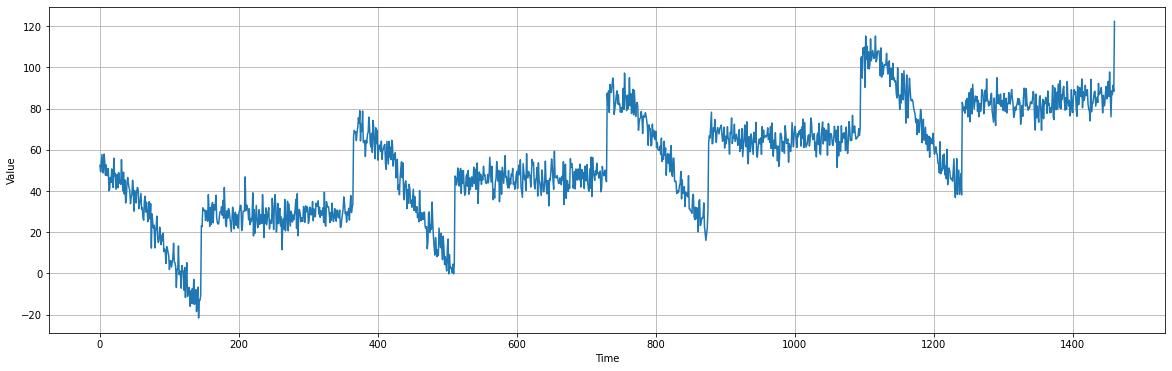

In [3]:
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise

plt.figure(figsize=(20, 6))
plot_series(time, series)
plt.show()

SPLIT THE SERIES INTO TRAINING AND VALIDATION PERIOD

In [4]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [5]:
## class to reset the cell state after every epochs
class ResetStatesCallback(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        self.model.reset_states()

LSTM MODEL

In [6]:
window_size = 30
train_set = sequential_window_dataset(x_train, window_size)

model = keras.models.Sequential([
  keras.layers.LSTM(100, return_sequences=True, stateful=True,
                    batch_input_shape=[1, None, 1]),
  keras.layers.LSTM(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
reset_states = ResetStatesCallback()
optimizer = keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100,
                    callbacks=[lr_schedule, reset_states])

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Epoch 1/100
33/33 [==============================] - 5s 31ms/step - loss: 44.3985 - mae: 44.8968 - lr: 1.0000e-08
Epoch 2/100
33/33 [==============================] - 1s 31ms/step - loss: 37.3249 - mae: 37.8212 - lr: 1.1220e-08
Epoch 3/100
33/33 [==============================] - 1s 31ms/step - loss: 33.1721 - mae: 33.6713 - lr: 1.2589e-08
Epoch 4/100
33/33 [==============================] - 1s 19ms/step - loss: 30.7593 - mae: 31.2588 - lr: 1.4125e-08
Epoch 5/100
33/33 [==============================] - 1s 19ms/step - loss: 28.7685 - mae: 29.2654 - lr: 1.5849e-08
Epoch 6/100
33/33 [==============================] - 1s 19ms/step - loss: 27.4545 - mae: 27.9483 - lr: 1.7783e-08
Epoch 7/100
33/33 [==============================] - 1s 19ms/step - loss: 26.7209 - mae: 27.2157 - lr: 1.9953e-08
Epoch 8/100
33/33 [==============================] - 1s 20ms/step - loss: 26.2240 - mae: 26.7200 - lr: 2.2387e-08
Epoch 9/100
33/33 [==============================] - 1s 19ms/step - loss: 25.7868 - mae:

(1e-08, 0.0001, 0.0, 30.0)

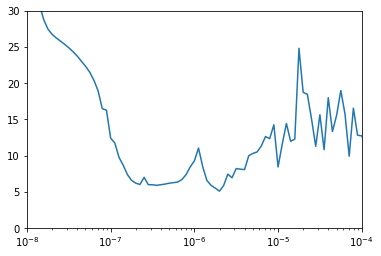

In [7]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [9]:
## training with training period and validation on validation period.
window_size = 30
train_set = sequential_window_dataset(x_train, window_size)
valid_set = sequential_window_dataset(x_valid, window_size)

model = keras.models.Sequential([
  keras.layers.LSTM(100, return_sequences=True, stateful=True,
                         batch_input_shape=[1, None, 1]),
  keras.layers.LSTM(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
optimizer = keras.optimizers.SGD(learning_rate=5e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
reset_states = ResetStatesCallback()
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint, reset_states])

Epoch 1/500
33/33 [==============================] - 6s 71ms/step - loss: 44.1507 - mae: 44.6486 - val_loss: 11.6951 - val_mae: 12.1911
Epoch 2/500
33/33 [==============================] - 1s 23ms/step - loss: 20.0379 - mae: 20.5344 - val_loss: 10.1759 - val_mae: 10.6661
Epoch 3/500
33/33 [==============================] - 1s 23ms/step - loss: 19.3158 - mae: 19.8117 - val_loss: 9.5123 - val_mae: 10.0036
Epoch 4/500
33/33 [==============================] - 1s 23ms/step - loss: 14.1070 - mae: 14.6000 - val_loss: 10.5654 - val_mae: 11.0569
Epoch 5/500
33/33 [==============================] - 1s 23ms/step - loss: 10.1140 - mae: 10.6041 - val_loss: 11.7581 - val_mae: 12.2496
Epoch 6/500
33/33 [==============================] - 1s 23ms/step - loss: 9.4776 - mae: 9.9641 - val_loss: 10.8680 - val_mae: 11.3587
Epoch 7/500
33/33 [==============================] - 1s 25ms/step - loss: 7.8515 - mae: 8.3380 - val_loss: 10.7773 - val_mae: 11.2691
Epoch 8/500
33/33 [==============================] - 

In [10]:
model = keras.models.load_model("my_checkpoint.h5")

FORECASTING USING THE LSTM MODEL

In [11]:
rnn_forecast = model.predict(series[np.newaxis, :, np.newaxis])
rnn_forecast = rnn_forecast[0, split_time - 1:-1, 0]

1/1 [==============================] - 1s 1s/step


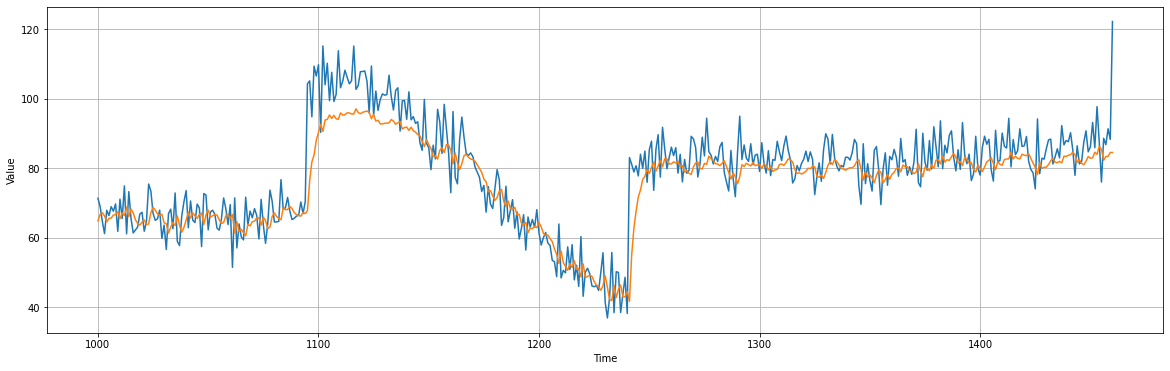

In [12]:
plt.figure(figsize=(20, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [13]:
keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

5.4726195

`LSTM MODEL MAE : 5.4`

****